# Interactive pipeline for motion correcting and denoising data

## Run Motion Correction --> PMD and do visualization directly in this notebook

In [22]:
#Plotting and dataloading
import tifffile
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from fastplotlib.widgets import ImageWidget

#Backend functionality
import jnormcorre as jnc
import numpy as np
import scipy
import torch
from scipy.signal import butter, filtfilt

import localmd
from localmd.decomposition import svd_new_temporal

%load_ext autoreload
%load_ext line_profiler

# Load the data. Note that our tools can also process full datasets without loading them into RAM.

In [3]:
filename = "Your_Data_File_Here.tiff"
raw_data_loader = tifffile.imread(filename).astype("float")
print(f"The shape of the input data is {raw_data_loader.shape}")

The shape of the input data is (8000, 512, 328)


# Inspect the data and decide how to spatially and/or temporally crop it

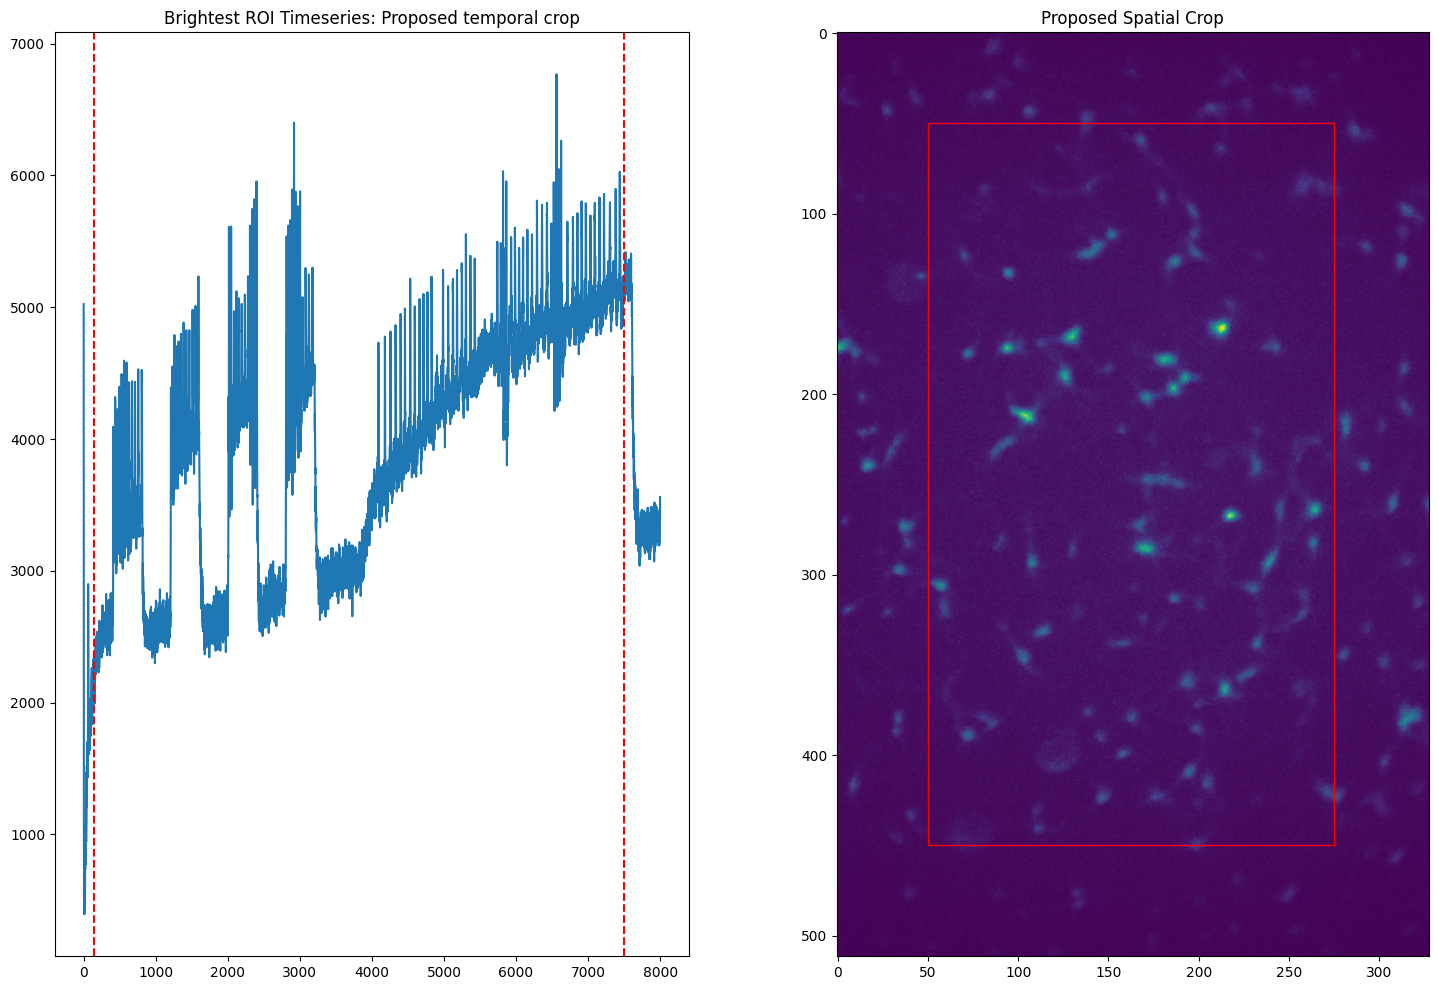

In [6]:
### Paramemters to modify:
start, end = 150, 7500 #Temporally cropping the fov
dim1_slice = [50, 450] #Trimming the "height" of the field of view
dim2_slice = [50, 275] #Trimming the "width" of the field of view
###


#Temporal crop error handling
start = max(0, start)
end = min(end, raw_data_loader.shape[0])

#Spatial crop error handling
dim1_slice[0] = max(dim1_slice[0], 0)
dim2_slice[0] = max(dim2_slice[0], 0)
dim1_slice[1] = min(dim1_slice[1], raw_data_loader.shape[1])
dim2_slice[1] = min(dim2_slice[1], raw_data_loader.shape[2])

def max_roi_average(ndarray):
    # Identify the brightest pixel in the first frame
    brightest_pixel = np.unravel_index(np.argmax(ndarray[0]), ndarray[0].shape)
    x, y = brightest_pixel

    # Define the boundaries of the 3x3 ROI
    x_min = max(x - 1, 0)
    x_max = min(x + 2, ndarray.shape[1])
    y_min = max(y - 1, 0)
    y_max = min(y + 2, ndarray.shape[2])

    # Extract the 3x3 ROI and compute the average over time
    roi = ndarray[:, x_min:x_max, y_min:y_max]
    roi_average = np.mean(roi, axis=(1, 2))

    return roi_average



representative_timeseries = max_roi_average(raw_data_loader)
fig, ax = plt.subplots(1, 2, figsize=(18, 12))
ax[0].plot(representative_timeseries)
ax[0].set_title("Brightest ROI Timeseries: Proposed temporal crop")
ax[0].axvline(x=start, color='red', linestyle='--')
ax[0].axvline(x=end, color='red', linestyle='--')

mean_img = np.mean(raw_data_loader[:1000], axis = 0)
ax[1].imshow(mean_img)

rect = patches.Rectangle([dim1_slice[0], dim2_slice[0]], dim2_slice[1] - dim2_slice[0], dim1_slice[1] - dim1_slice[0], 
                         linewidth=1, edgecolor='r', facecolor='none')
ax[1].add_patch(rect)
ax[1].set_title("Proposed Spatial Crop")
plt.show()

raw_dataloader_crop = raw_data_loader[start:end, dim1_slice[0]:dim1_slice[1], dim2_slice[0]:dim2_slice[1]]

# Run motion correction to identify the data template

In [23]:
# These parameters are for rigid registration
max_shifts = (7, 7)
frames_per_split = 500
num_splits_to_process_rig = 5
niter_rig = 4
save_movie = False

##These parameters are for estimating a piecewise rigid template
pw_rigid = False
strides = (50, 50)
overlaps = (5, 5)
max_deviation_rigid = 5
corrector = jnc.MotionCorrect(raw_dataloader_crop, max_shifts=max_shifts, frames_per_split=frames_per_split,
                                                num_splits_to_process_rig=num_splits_to_process_rig, strides=strides,
                                                       overlaps=overlaps, max_deviation_rigid = max_deviation_rigid, niter_rig=niter_rig, pw_rigid = pw_rigid)



frame_corrector, output_file = corrector.motion_correct(
    template=None, save_movie=save_movie
)

motion_correction_dataloader = jnc.RegistrationArray(frame_corrector, raw_dataloader_crop, pw_rigid=False)

# Given the template, run fused motion correction + PMD compression & denoising

In [24]:
block_sizes = [32, 32]
frame_range = 5000
max_components = 20
background_rank = 3

full_pmd_movie = localmd.localmd_decomposition(motion_correction_dataloader, block_sizes, frame_range, max_components=max_components, 
                          background_rank=background_rank, sim_conf=5, frame_batch_size = 1000,
                          dtype='float32', pixel_batch_size=5000, max_consecutive_failures = 1, rank_prune=True, temporal_avg_factor=10)

# Visualize the results using fastplotlib

In [25]:
'''
Modify the below timeslice value; this amount of motion corrected, PMD, and High-Passed PMD data is loaded into RAM for the visualization
If you want to load the full dataset, set timeslice = slice(0, raw_data_loader_crop.shape[0])
'''

movies = [raw_dataloader_crop,
          motion_correction_dataloader,
          full_pmd_movie]

iw = ImageWidget(data=movies, 
                 figure_shape=(1,3),
                 names=['Raw', 'Moco', 'PMD'],
                histogram_widget=False)

iw.show()


# Save the results to a .npz file. This file will be loaded by the demixing workflow to extract ROI and Signals

In [9]:
filename = f"Decomposition_File_{dim1_slice[0]}_{dim1_slice[1]}_{dim2_slice[0]}_{dim2_slice[1]}.npz"
np.savez(filename, pmd = full_pmd_movie)

# Optional: Some workflows might involve running a pixel-wise filter. If this filter is a linear operation, we can operate directly on the temporal basis of the PMD representation.

In [20]:
#####
## Specify the frequency parameters for the high-pass filter. 
#####
cutoff_freq_in_hz = 5 # Everything below this frequency gets truncated 
sampling_rate_hz = 800 # Frame rate of the data
#####


### Everything below does not change

##Define the filtering operation
def high_pass_filter(data: np.ndarray,
                     cutoff: float,
                     sampling_rate: float, order=5):
    """
    data (np.ndarray): 1D time series
    cutoff (float): The frequency cutoff in hertz
    sampling_rate (float): The sampling rate of the data
    order (int): Order of the butterworth filter for the sampling rate

    Returns:
        filtered_data (np.ndarray): Shape (T,). 1D high-pass filtered time series
    """
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

def high_pass_filter_V(V: np.ndarray,
                       cutoff: float,
                       sampling_rate: float):
    """
    Runs a high pass filter on all temporal basis vectors from the PMD representation

    Code is serially run on CPU right now for clarity, super easy to run on GPU

    Args:
        V (np.ndarray): Shape (PMD Rank, Number of Frames). PMD temporal basis
        cutoff (float): The frequency cutoff in hertz
        sampling_rate (float): The sampling rate of the data

    Returns:
        V_hp (np.ndarray): Shape (PMD Rank, Number of Frames). High-passed PMD temporal basis vectors
    """
    V_hp = np.zeros_like(V)
    
    for k in range(V.shape[0]):
        V_hp[k, :] = high_pass_filter(V[k, :], cutoff, sampling_rate)
    return V_hp



#Get the existing U_sparse, R, s, V matrices, high-pass filter V
U_sparse = full_pmd_movie.U_sparse
R = full_pmd_movie.R
s = full_pmd_movie.s
V = full_pmd_movie.V
V_filt = high_pass_filter_V(V, cutoff_freq_in_hz, sampling_rate_hz)
T, d1, d2 = full_pmd_movie.shape

#Get the new factorization (the temporally high-passed movie) and construct a PMD array
R_hp, s_hp, V_hp = [np.array(mat) for mat in svd_new_temporal(R, s, V_filt)]
zero_filter = s_hp != 0
R_hp = R_hp[:, zero_filter]
s_hp = s_hp[zero_filter]
V_hp = V_hp[zero_filter, :]
hp_pmd_movie = localmd.pmdarray.PMDArray(full_pmd_movie.U_sparse.tocoo(), R_hp, s_hp, V_hp, full_pmd_movie.shape, 
                                         full_pmd_movie.order, full_pmd_movie.mean_img, full_pmd_movie.var_img)



fig, ax = plt.subplots(1, 3, figsize = (15, 10))
fig.suptitle("800 Hz Data, 4 x 4 ROI Analysis")
r, c = np.unravel_index(np.argmax(raw_dataloader_crop[0]), raw_dataloader_crop.shape[1:])
print(f"{r} and {c}")
ts = np.mean(raw_dataloader_crop[:, max(0, r-4):r+4, max(0, c-4):c+4], axis = (1,2))
ax[0].plot(ts[:])
ax[0].set_title("Temporal Average of 4 x 4 ROI")
ax[0].set_xlabel("Frames")
ax[0].set_yticks([])

high_pass_ts = high_pass_filter(ts, cutoff_freq_in_hz, sampling_rate_hz)
ax[1].plot(high_pass_ts[:])
ax[1].set_title(f"High Pass Filt: {cutoff_freq_in_hz} Hz Cutoff")

ax[2].plot((ts - high_pass_ts)[:])
ax[2].set_title("Low Pass Filt")

plt.show()


# Optional: Save the high-pass filtered PMD video.

In [18]:
filename = f"Decomposition_File_High_Pass_{cutoff_freq_in_hz}_{dim1_slice[0]}_{dim1_slice[1]}_{dim2_slice[0]}_{dim2_slice[1]}.npz"
np.savez(filename, pmd = hp_pmd_movie)

# Visualize all results: Raw, Motion Corrected, PMD, High-Pass Filtered Data

In [21]:
'''
Modify the below timeslice value; this amount of motion corrected, PMD, and High-Passed PMD data is loaded into RAM for the visualization
If you want to load the full dataset, set timeslice = slice(0, raw_data_loader_crop.shape[0])
'''

movies = [raw_dataloader_crop,
          motion_correction_dataloader,
          full_pmd_movie,
          hp_pmd_movie]

iw = ImageWidget(data=movies, 
                 figure_shape=(1,4),
                 names=['Raw', 'Moco', 'PMD', 'HP Filter PMD'],
                histogram_widget=False)

iw.show()
